CODE BLOCK: 1

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_8")

In [3]:
from utils import *
from models import *

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

CODE BLOCK: 2

In [5]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 3

In [6]:
# # Train data transformations
# train_transforms = transforms.Compose([
#     transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
#     transforms.Resize((28, 28)),
#     transforms.RandomRotation((-15., 15.), fill=0),
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)),
#     ])

# # Test data transformations
# test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
#     ])

train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))
     ])

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
     ])



CODE BLOCK: 4

In [7]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 96490555.19it/s] 


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


CODE BLOCK: 5

In [8]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CODE BLOCK: 6

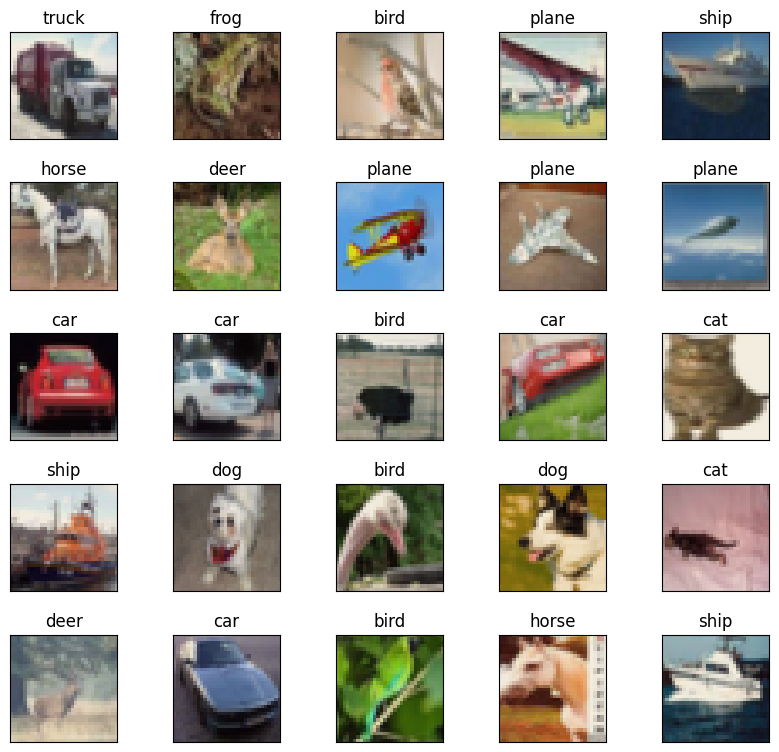

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
plot_samples_cifar10(batch_data,batch_label,classes, denormalise = True)


In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = cifar_model_gn().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
         GroupNorm-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 16, 32, 32]             528
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 24, 16, 16]           3,480
             ReLU-10           [-1, 24, 16, 16]               0
        GroupNorm-11           [-1, 24, 16, 16]              48
           Conv2d-12           [-1, 32, 16, 16]           6,944
             ReLU-13           [-1, 32, 16, 16]               0
        GroupNorm-14           [-1, 32,

CODE BLOCK: 8

In [11]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [12]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=1.6765 Batch_id=97 Accuracy=30.80: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]


Test set: Average loss: 1.5738, Accuracy: 4315/10000 (43.15%)

Epoch 2


Train: Loss=1.3794 Batch_id=97 Accuracy=47.01: 100%|██████████| 98/98 [00:16<00:00,  6.07it/s]


Test set: Average loss: 1.3617, Accuracy: 5017/10000 (50.17%)

Epoch 3


Train: Loss=1.1993 Batch_id=97 Accuracy=53.99: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]


Test set: Average loss: 1.1937, Accuracy: 5671/10000 (56.71%)

Epoch 4


Train: Loss=1.0864 Batch_id=97 Accuracy=59.49: 100%|██████████| 98/98 [00:16<00:00,  6.00it/s]


Test set: Average loss: 1.0736, Accuracy: 6102/10000 (61.02%)

Epoch 5


Train: Loss=0.9642 Batch_id=97 Accuracy=63.71: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]


Test set: Average loss: 0.9883, Accuracy: 6432/10000 (64.32%)

Epoch 6


Train: Loss=0.8595 Batch_id=97 Accuracy=67.26: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]


Test set: Average loss: 0.9235, Accuracy: 6750/10000 (67.50%)

Epoch 7


Train: Loss=0.8605 Batch_id=97 Accuracy=69.71: 100%|██████████| 98/98 [00:16<00:00,  5.99it/s]


Test set: Average loss: 0.8782, Accuracy: 6903/10000 (69.03%)

Epoch 8


Train: Loss=0.8320 Batch_id=97 Accuracy=71.76: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]


Test set: Average loss: 0.8475, Accuracy: 7004/10000 (70.04%)

Epoch 9


Train: Loss=0.7362 Batch_id=97 Accuracy=73.26: 100%|██████████| 98/98 [00:15<00:00,  6.26it/s]


Test set: Average loss: 0.8234, Accuracy: 7124/10000 (71.24%)

Epoch 10


Train: Loss=0.5885 Batch_id=97 Accuracy=74.88: 100%|██████████| 98/98 [00:15<00:00,  6.18it/s]


Test set: Average loss: 0.8126, Accuracy: 7095/10000 (70.95%)

Epoch 11


Train: Loss=0.6794 Batch_id=97 Accuracy=76.71: 100%|██████████| 98/98 [00:17<00:00,  5.76it/s]


Test set: Average loss: 0.7805, Accuracy: 7279/10000 (72.79%)

Epoch 12


Train: Loss=0.6896 Batch_id=97 Accuracy=77.45: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]


Test set: Average loss: 0.8094, Accuracy: 7154/10000 (71.54%)

Epoch 13


Train: Loss=0.5856 Batch_id=97 Accuracy=78.86: 100%|██████████| 98/98 [00:16<00:00,  6.01it/s]


Test set: Average loss: 0.6979, Accuracy: 7562/10000 (75.62%)

Epoch 14


Train: Loss=0.5039 Batch_id=97 Accuracy=79.17: 100%|██████████| 98/98 [00:15<00:00,  6.18it/s]


Test set: Average loss: 0.7363, Accuracy: 7425/10000 (74.25%)

Epoch 15


Train: Loss=0.5860 Batch_id=97 Accuracy=80.38: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]


Test set: Average loss: 0.7384, Accuracy: 7499/10000 (74.99%)

Epoch 16


Train: Loss=0.4848 Batch_id=97 Accuracy=81.05: 100%|██████████| 98/98 [00:16<00:00,  5.94it/s]


Test set: Average loss: 0.7045, Accuracy: 7555/10000 (75.55%)

Epoch 17


Train: Loss=0.5399 Batch_id=97 Accuracy=81.89: 100%|██████████| 98/98 [00:15<00:00,  6.26it/s]


Test set: Average loss: 0.7190, Accuracy: 7515/10000 (75.15%)

Epoch 18


Train: Loss=0.4469 Batch_id=97 Accuracy=82.21: 100%|██████████| 98/98 [00:15<00:00,  6.28it/s]


Test set: Average loss: 0.7066, Accuracy: 7581/10000 (75.81%)

Epoch 19


Train: Loss=0.5060 Batch_id=97 Accuracy=82.99: 100%|██████████| 98/98 [00:16<00:00,  5.91it/s]


Test set: Average loss: 0.7021, Accuracy: 7632/10000 (76.32%)

Epoch 20


Train: Loss=0.4912 Batch_id=97 Accuracy=83.57: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]


Test set: Average loss: 0.6620, Accuracy: 7731/10000 (77.31%)



CODE BLOCK: 11

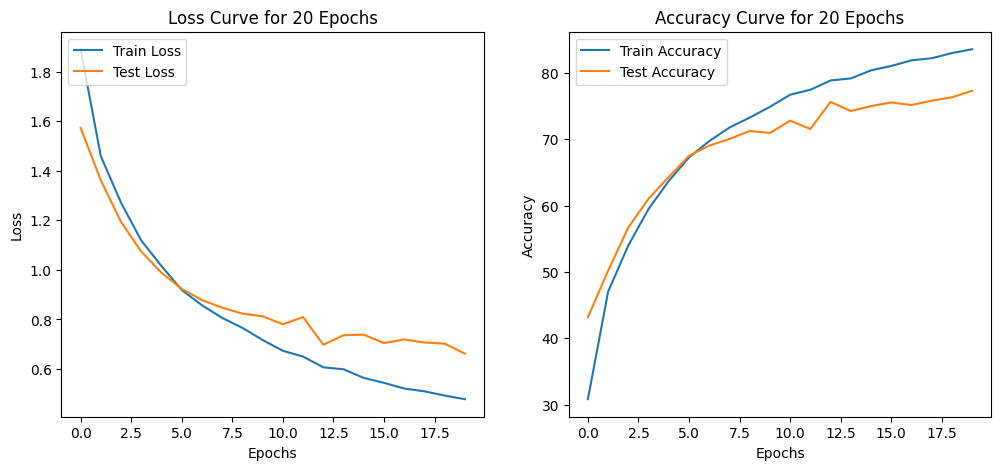

In [15]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc, num_epochs)

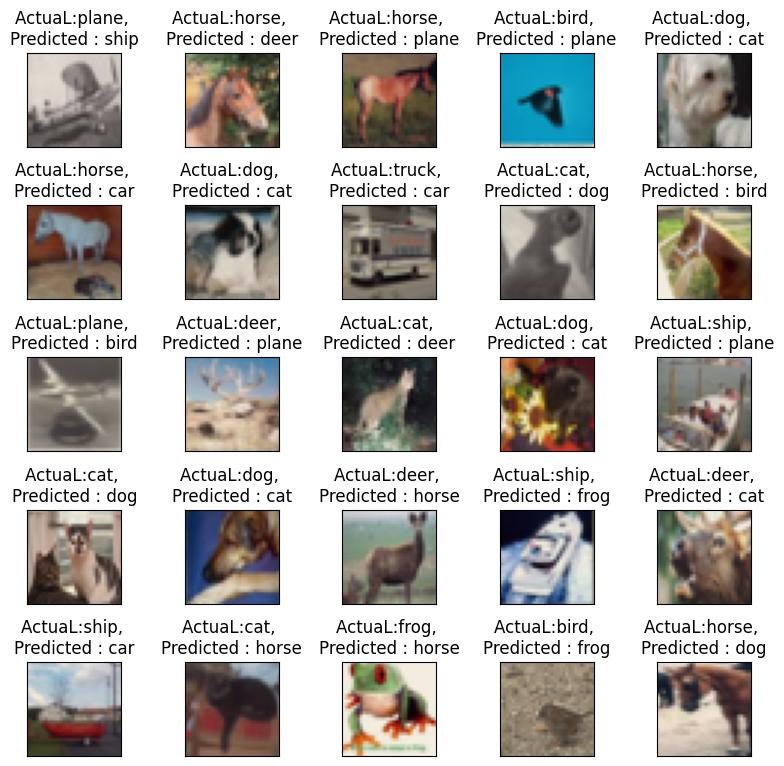

In [16]:
# Show Misclassified images
for batch_idx, (data, target) in enumerate(test_loader):
  data, target = data.to(device), target.to(device)
  output = model(data)
  output_label = output.argmax(dim=1)
  op_ne_target = output.argmax(dim=1).ne(target)
  actual_label = target[op_ne_target].to('cpu')
  predicted_label = output_label[op_ne_target].to('cpu')
  images = data[op_ne_target].to('cpu')
  plot_misclassified_samples(images, actual_label, predicted_label,classes, denormalise = True)
  break
